### 5.2 Whole Slide Scoring - Prediction Confidence Segmentation

Prediction confidence heatmaps were segmented to generate the CNN model-based whole-slide scores. 

First, a CNN confidence threshold was applied to the heatmaps, with only prediction confidences higher than the threshold retained, indicating the existences of plaques predicted with high confidence. Morphological opening and closing operations were then performed to smooth the masks, and prediction areas exceeding a size threshold set to eliminate CNN-noise provided the predicted quantities of Aβ pathologies (ie. cored plaque, diffuse plaque, and CAA). 

These two hyperparameters, CNN confidence threshold (core: 0.1; diffuse: 0.95; CAA: 0.9) and size threshold (cored: 100; diffuse: 1; CAA: 200), were optimized exclusively by statistical analysis on the combined training and validation sets (32 WSIs). These were then used on the hold-out test set with 30 unseen WSIs to show the generalizability. 

In [1]:
import csv
import glob, os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats

from tqdm import tqdm

In [4]:
CSV_DIR = 'data/outputs/CNNscore/WSI_CERAD_AREA.csv'
HEATMAP_DIR = 'data/outputs/heatmaps'
# HEATMAP_DIR = 'data/outputs/heatmaps_stride16/'
SAVE_DIR = 'data/outputs/CNNscore/'

In [5]:
# IMG_DIR = 'data/norm_tiles'
filenames = sorted(os.listdir(HEATMAP_DIR))
filenames = [os.path.splitext(file)[0] for file in filenames]
print(filenames)

['NA3777-02_AB', 'NA4077-02_AB']


In [22]:
test = pd.DataFrame({"WSI_ID": filenames})
test.to_csv(CSV_DIR, index=False)

In [4]:
test = pd.read_csv(CSV_DIR)
print(test)

          WSI_ID
0   NA3777-02_AB
1   NA4077-02_AB
2   NA4092-02_AB
3   NA4107-02_AB
4   NA4160-02_AB
5   NA4195-02_AB
6   NA4256-02_AB
7   NA4299-02_AB
8   NA4391-02_AB
9   NA4450-02_AB
10  NA4463-02_AB
11  NA4471-02_AB
12  NA4553-02_AB
13  NA4626-02_AB
14  NA4672-02_AB
15  NA4675-02_AB
16  NA4691-02_AB
17  NA4695-02_AB


In [3]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [10]:
BRAINSEG_NP_DIR = 'data/brainseg/numpy/'
SAVE_IMG_DIR = 'data/outputs/masked_plaque/images/'
SAVE_NP_DIR = 'data/outputs/masked_plaque/numpy/'
print(os.listdir(BRAINSEG_NP_DIR))

['NA3777-02_AB.npy', 'NA4077-02_AB.npy']


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_seg(seg_np) :
    

In [76]:
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [77]:
from PIL import Image
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
# import lxml.etree as ET
from tqdm import tqdm

def method_6(mask_img: "Image", down_factor=4) -> "NDArray[np.uint8]":
    """Downsample => Area_opening (Remove local maxima) =>
    Swap index of GM and WM => Area_opening => Swap index back =>
    Area_closing => Morphological opening => Upsample"""
    # pylint: disable=invalid-name
    def swap_GM_WM(arr):
        """Swap GM and WM in arr (swaps index 1 and index 2)"""
        arr_1 = (arr == 1)
        arr[arr == 2] = 1
        arr[arr_1] = 2
        del arr_1
        return arr
    # pylint: enable=invalid-name

    mask_img = Image.fromarray(mask_img)
    width, height = mask_img.width, mask_img.height
    area_threshold_prop = 0.05
    area_threshold = int(area_threshold_prop * width * height // down_factor**2)

    # Downsample the image
    mask_arr = np.array(
        mask_img.resize((width // down_factor, height // down_factor), Image.NEAREST))
    del mask_img
    print('Finish downsampling')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=320000 // down_factor**2)
    print('Finish area_opening #1')

    # Swap index of GM and WM
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=320000 // down_factor**2)
    print('Finish area_opening #2')

    # Swap index back
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index back')

    # Apply area_closing to remove local minima with area < 12500 px
    mask_arr = morphology.area_closing(mask_arr, area_threshold=200000 // down_factor**2)
    print('Finish area_closing')

    # Apply remove_small_objects to remove tissue residue with area < 0.05 * width * height
    tissue_arr = morphology.remove_small_objects(mask_arr > 0, min_size=area_threshold,
                                                 connectivity=2)
    mask_arr[np.invert(tissue_arr)] = 0
    del tissue_arr
    print('Finish remove_small_objects')

    # Apply opening with disk-shaped kernel (r=8) to smooth boundary
    mask_arr = morphology.opening(mask_arr, selem=morphology.disk(radius=32 // down_factor))
    print('Finish morphological opening')

    # Upsample the output
    mask_arr = np.array(Image.fromarray(mask_arr).resize((width, height), Image.NEAREST))
    print('Finish upsampling')

    return mask_arr

In [11]:
# BrainSeg Post-processing Directories
BRAINSEG_NP_PRE_DIR = 'data/brainseg/numpy/'
POST_IMG_DIR = 'data/postprocess/images/'
POST_NP_DIR = 'data/postprocess/numpy/'

# Counted Plaques Save Directories
SAVE_IMG_DIR = 'data/outputs/masked_plaque/images/'
SAVE_NP_DIR = 'data/outputs/masked_plaque/numpy/'

In [79]:
# seg_pic = np.load(BRAINSEG_NP_DIR + filenames[0] + ".npy")

# Post-process BrainSeg
for filename in tqdm(filenames) :
    fileLoc = BRAINSEG_NP_PRE_DIR + filename + ".npy"
    print("Loading: " + fileLoc)
    seg_pic = np.load(fileLoc)
    processed = method_6(seg_pic)
    np.save(POST_NP_DIR+filename, processed)
    saveBrainSegImage(processed, \
                      POST_IMG_DIR + filename + '.png')

  0%|          | 0/18 [00:00<?, ?it/s]

Loading: data/brainseg/numpy/NA3777-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


  6%|▌         | 1/18 [00:04<01:18,  4.64s/it]

Saved at: data/postprocess/images/NA3777-02_AB.png
Loading: data/brainseg/numpy/NA4077-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 11%|█         | 2/18 [00:10<01:21,  5.09s/it]

Saved at: data/postprocess/images/NA4077-02_AB.png
Loading: data/brainseg/numpy/NA4092-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 17%|█▋        | 3/18 [00:16<01:19,  5.27s/it]

Saved at: data/postprocess/images/NA4092-02_AB.png
Loading: data/brainseg/numpy/NA4107-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 22%|██▏       | 4/18 [00:21<01:10,  5.06s/it]

Saved at: data/postprocess/images/NA4107-02_AB.png
Loading: data/brainseg/numpy/NA4160-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 28%|██▊       | 5/18 [00:25<01:03,  4.91s/it]

Saved at: data/postprocess/images/NA4160-02_AB.png
Loading: data/brainseg/numpy/NA4195-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 33%|███▎      | 6/18 [00:29<00:56,  4.67s/it]

Saved at: data/postprocess/images/NA4195-02_AB.png
Loading: data/brainseg/numpy/NA4256-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 39%|███▉      | 7/18 [00:35<00:54,  4.95s/it]

Saved at: data/postprocess/images/NA4256-02_AB.png
Loading: data/brainseg/numpy/NA4299-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 44%|████▍     | 8/18 [00:40<00:48,  4.88s/it]

Saved at: data/postprocess/images/NA4299-02_AB.png
Loading: data/brainseg/numpy/NA4391-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 50%|█████     | 9/18 [00:44<00:42,  4.71s/it]

Saved at: data/postprocess/images/NA4391-02_AB.png
Loading: data/brainseg/numpy/NA4450-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 56%|█████▌    | 10/18 [00:49<00:38,  4.78s/it]

Saved at: data/postprocess/images/NA4450-02_AB.png
Loading: data/brainseg/numpy/NA4463-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 61%|██████    | 11/18 [00:54<00:33,  4.80s/it]

Saved at: data/postprocess/images/NA4463-02_AB.png
Loading: data/brainseg/numpy/NA4471-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 67%|██████▋   | 12/18 [01:00<00:30,  5.13s/it]

Saved at: data/postprocess/images/NA4471-02_AB.png
Loading: data/brainseg/numpy/NA4553-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 72%|███████▏  | 13/18 [01:05<00:26,  5.32s/it]

Saved at: data/postprocess/images/NA4553-02_AB.png
Loading: data/brainseg/numpy/NA4626-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 78%|███████▊  | 14/18 [01:09<00:19,  4.89s/it]

Saved at: data/postprocess/images/NA4626-02_AB.png
Loading: data/brainseg/numpy/NA4672-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 83%|████████▎ | 15/18 [01:13<00:13,  4.42s/it]

Saved at: data/postprocess/images/NA4672-02_AB.png
Loading: data/brainseg/numpy/NA4675-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 89%|████████▉ | 16/18 [01:17<00:08,  4.49s/it]

Saved at: data/postprocess/images/NA4675-02_AB.png
Loading: data/brainseg/numpy/NA4691-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 94%|█████████▍| 17/18 [01:21<00:04,  4.39s/it]

Saved at: data/postprocess/images/NA4691-02_AB.png
Loading: data/brainseg/numpy/NA4695-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


100%|██████████| 18/18 [01:26<00:00,  4.79s/it]

Saved at: data/postprocess/images/NA4695-02_AB.png


In [28]:
file = pd.read_csv(CSV_DIR)
filenames = list(file['WSI_ID'])
img_class = ['cored', 'diffuse', 'caa']

# two hyperparameters
confidence_thresholds = [0.1, 0.95, 0.9]
pixel_thresholds = [100, 1, 200]

In [29]:
# UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18,
# use 'connectivity' instead. For neighbors=8, use connectivity=2
#   This is separate from the ipykernel package so we can avoid doing imports until

def count_blobs(mask,
               threshold=1500):
#     labels = measure.label(mask, neighbors=8, background=0)
    labels = measure.label(mask, connectivity=2, background=0)
    img_mask = np.zeros(mask.shape, dtype='uint8')
    labeled_mask = np.zeros(mask.shape, dtype='uint16')
    sizes = []
    locations = []
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > threshold:
            sizes.append(numPixels)
            img_mask = cv2.add(img_mask, labelMask)
            
            # Save confirmed unique location of plaque
            labeled_mask[labels==label] = label
#             location = np.where(labelMask == 255)
#             locations.append(location)

#             row_loc, col_loc = np.where(labelMask == 255)
#             print("row_loc, col_loc", (row_loc, col_loc))

    return sizes, img_mask, labeled_mask

In [26]:
test_array = np.asarray([1, 0, 1, 2, 3, 4, 2, 4, 4, 4], dtype=np.uint8)
elements, counts = np.unique(test_array, return_counts=True)
print("Type of Elements: ", elements)
print("Number of Counts: ", counts)
idx_tuple = np.where(counts == np.amax(counts))
row = idx_tuple[0]
print(row)
print(np.asarray([2], dtype=np.uint8).shape)

Type of Elements:  [0 1 2 3 4]
Number of Counts:  [1 2 2 1 4]
[4]
(1,)


In [13]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_mask(mask_array) :
    fig = plt.figure(figsize=(45,15))
    ax = fig.add_subplot(111)

    im = ax.imshow(mask_array, cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    
    return plt.show()

In [31]:
from PIL import Image
def saveMask(mask_array, save_dir) :
    
    mask_array = np.repeat(mask_array[:,:, np.newaxis], 3, axis=2)
    
    # mask_array[:,:,0] = RED, mask_array[:,:,1] = Green, mask_array[:,:,2] = Blue
    idx = np.where(mask_array[:,:,0] == 255)  # Index of label 1 (WM)

    # For label 0, leave as black color
    # For label 1, set to cyan color: R0G255B255
    mask_array[:,:,0].flat[np.ravel_multi_index(idx, mask_array[:,:,0].shape)] = 0
    mask_array[:,:,1].flat[np.ravel_multi_index(idx, mask_array[:,:,1].shape)] = 255
    mask_array[:,:,2].flat[np.ravel_multi_index(idx, mask_array[:,:,2].shape)] = 255
#     # For label 2, set to yellow color: R255G255B0
#     mask_array[:,:,0].flat[np.ravel_multi_index(idx_2, mask_array[:,:,0].shape)] = 255
#     mask_array[:,:,1].flat[np.ravel_multi_index(idx_2, mask_array[:,:,1].shape)] = 255
#     mask_array[:,:,2].flat[np.ravel_multi_index(idx_2, mask_array[:,:,2].shape)] = 0

    mask_array = mask_array.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(mask_array, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [74]:
def classify_blobs(labeled_mask, seg_area) :
    
    # 0: Background, 1: GM, 2: WM
    count_dict = {0: 0, 1: 0, 2: 0, "uncounted": 0}
    # Loop over unique components
    for label in np.unique(labeled_mask) :
        if label == 0:
            continue
            
        plaque_loc = np.where(labeled_mask == label)
        plaque_area = seg_area[plaque_loc]
        indexes, counts = np.unique(plaque_area, return_counts=True)
        class_idx = indexes[np.where(counts == np.amax(counts))]
        
        try:
            class_idx = class_idx.item()
            count_dict[class_idx] += 1
                
        except:
            uncounted += 1
            count_dict["uncounted"] += 1
            
    return count_dict, count_dict[0], count_dict[1], count_dict[2], count_dict["uncounted"]
            

In [ ]:
def locatePlaque(mask_array, seg_array) :
    
    idx = np.where(mask_array == 255)
    seg_array[idx]

In [75]:
new_file = file
for index in [0,1,2]:
    preds = np.zeros(len(file))
    confidence_threshold = confidence_thresholds[index]
    pixel_threshold = pixel_thresholds[index]
    
    bg = np.zeros(len(file))
    wm = np.zeros(len(file))
    gm = np.zeros(len(file))
    unknowns = np.zeros(len(file))

    for i, WSIname in tqdm(enumerate(filenames)):
        try:
            heatmap_path = HEATMAP_DIR+'new_WSI_heatmap_{}.npy'.format(WSIname)
            h = np.load(heatmap_path)

        except:
            heatmap_path = HEATMAP_DIR+'{}.npy'.format(WSIname)
            h = np.load(heatmap_path)
            seg_path = BRAINSEG_NP_DIR+'{}.npy'.format(WSIname)
            seg = np.load(seg_path)

        mask = h[index] > confidence_threshold
        mask = mask.astype(np.float32)
        
#         print("Initial Mask:", mask)
#         plot_mask(mask)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

        # Apply morphological closing, then opening operations 
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        
#         print("Denoised Mask:", closing)
#         print("Denoised Mask Shape: ", closing.shape)
#         plot_mask(closing)

        labels, img_mask, labeled_mask = count_blobs(closing, threshold=pixel_threshold)
        counts, bg[i], wm[i], gm[i], unknowns[i] = classify_blobs(labeled_mask, seg)
    
        save_img = SAVE_IMG_DIR + WSIname \
                    + "_" + img_class[index] + ".png"
        save_np = SAVE_NP_DIR + WSIname \
                    + "_" + img_class[index] + ".npy"
        np.save(save_np, labeled_mask)
        saveMask(img_mask, save_img)
        

#         print(labels)
#         print(img_mask.shape)
        preds[i] = len(labels)
        

    print(confidence_threshold, pixel_threshold)

    new_file['CNN_{}_count'.format(img_class[index])] = preds
    new_file['BG_{}_count'.format(img_class[index])] = bg
    new_file['GM_{}_count'.format(img_class[index])] = gm
    new_file['WM_{}_count'.format(img_class[index])] = wm
    new_file['{}_no-count'.format(img_class[index])] = unknowns
    

new_file.to_csv(SAVE_DIR+'CNN_vs_CERAD.csv', index=False)

1it [01:06, 66.31s/it]

Saved at: data/postprocess/images/NA3777-02_AB_cored.png


2it [02:15, 67.23s/it]

Saved at: data/postprocess/images/NA4077-02_AB_cored.png


3it [03:09, 63.26s/it]

Saved at: data/postprocess/images/NA4092-02_AB_cored.png


4it [03:42, 54.24s/it]

Saved at: data/postprocess/images/NA4107-02_AB_cored.png


4it [04:05, 61.27s/it]


KeyboardInterrupt: 

[   0    2    4    6    7    9   12   19   23   25   27   29   34   36
   41   43   51   57   62   68   73   75   79   82   86   87   95  101
  122  130  132  136  141  145  151  157  160  161  172  178  181  182
  183  184  185  203  216  218  226  236  239  249  250  253  263  274
  294  295  299  300  303  306  322  325  328  334  340  341  342  357
  362  366  367  374  378  379  381  384  385  393  394  399  400  408
  418  419  424  427  429  437  445  447  458  460  462  464  468  470
  473  474  480  481  497  498  502  506  507  513  515  518  521  526
  538  539  540  543  544  550  552  559  568  574  576  578  597  598
  602  606  611  617  620  621  629  632  634  637  646  655  657  658
  667  668  671  672  673  675  676  678  679  681  687  693  695  698
  700  708  715  717  720  721  722  724  727  728  732  734  739  744
  747  748  757  758  759  760  763  765  767  768  772  773  775  778
  779  780  784  785  787  789  794  795  802  807  810  811  814  816
  829 

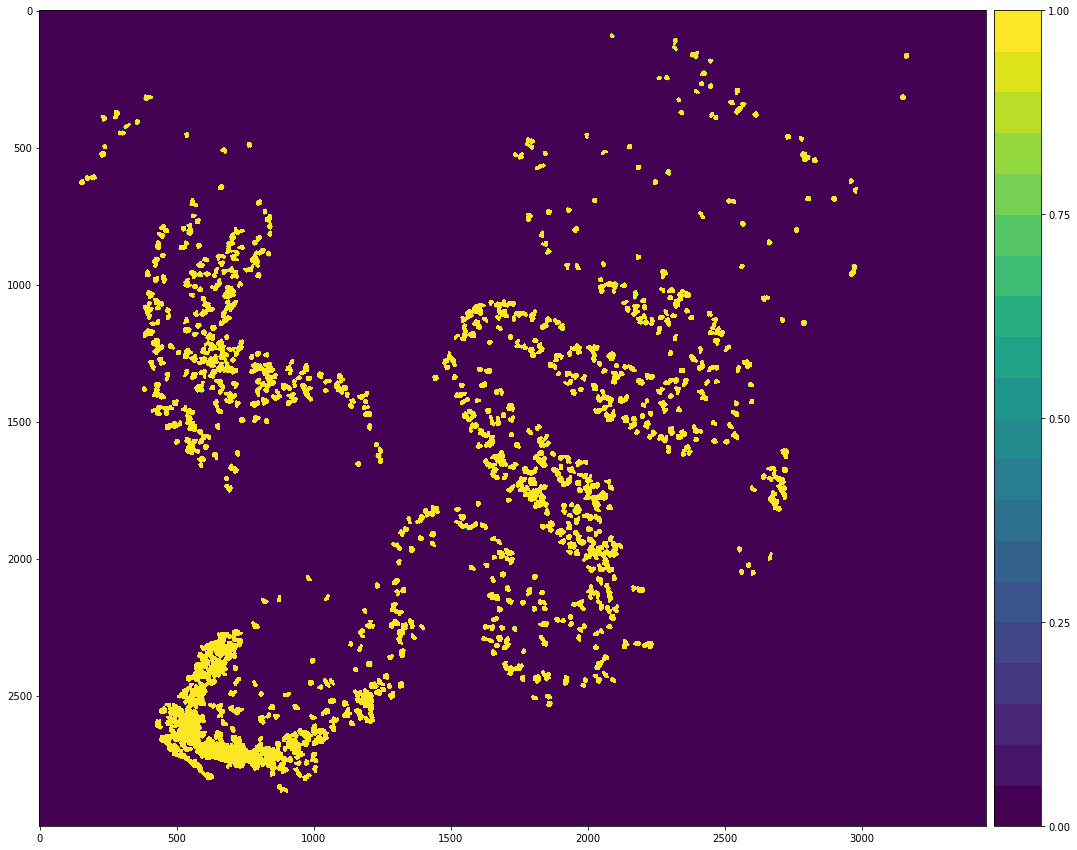

In [39]:
# Double checking Plaque Location
inspect_plaque = np.load(SAVE_NP_DIR + filenames[0] + "_cored.npy")
inspect_seg = np.load(BRAINSEG_NP_DIR + filenames[0] + ".npy")
print(np.unique(inspect_plaque))
# print(np.where(inspect_plaque == 16))
plot_mask(inspect_plaque)

In [19]:
plaque_loc = np.where(inspect_plaque == 2)
print(plaque_loc)
print(np.amax(np.unique(inspect_plaque)))

(array([ 86,  86,  86,  86,  86,  86,  87,  87,  87,  87,  87,  87,  88,
        88,  88,  88,  88,  88,  88,  88,  88,  88,  89,  89,  89,  89,
        89,  89,  89,  89,  89,  89,  90,  90,  90,  90,  90,  90,  90,
        90,  90,  90,  90,  90,  91,  91,  91,  91,  91,  91,  91,  91,
        91,  91,  91,  91,  92,  92,  92,  92,  92,  92,  92,  92,  92,
        92,  92,  92,  92,  92,  93,  93,  93,  93,  93,  93,  93,  93,
        93,  93,  93,  93,  93,  93,  94,  94,  94,  94,  94,  94,  94,
        94,  94,  94,  94,  94,  94,  94,  94,  95,  95,  95,  95,  95,
        95,  95,  95,  95,  95,  95,  95,  95,  95,  95,  96,  96,  96,
        96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  97,
        97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
        98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
        98,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100]), array([2087, 2

In [49]:
from skimage.color import hsv2rgb
from PIL import Image

def saveUniqueMaskImage(maskArray, save_dir) :
    '''
    Inputs:
        - maskArray : Numpy Array containing Unique plaque
        - save_dir : String for Save Directory
    '''
    
    max_val = np.amax(np.unique(maskArray))
#     print("Maximum Value = ", max_val)
    maskArray = np.asarray(maskArray, dtype=np.float64)
    maskArray = np.repeat(maskArray[:,:, np.newaxis], 3, axis=2)

    for label in np.unique(maskArray) :

        # For label 0, leave as black color (BG)
        if label == 0:
            continue

        idx = np.where(maskArray[:,:,0] == label) 

        # For label, create HSV space based on unique labels
        maskArray[:,:,0].flat[np.ravel_multi_index(idx, maskArray[:,:,0].shape)] = label / max_val
        maskArray[:,:,1].flat[np.ravel_multi_index(idx, maskArray[:,:,1].shape)] = label % max_val
        maskArray[:,:,2].flat[np.ravel_multi_index(idx, maskArray[:,:,2].shape)] = 1

    rgb_maskArray = hsv2rgb(maskArray)
    rgb_maskArray = rgb_maskArray * 255
    rgb_maskArray = rgb_maskArray.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    
    save_img = Image.fromarray(rgb_maskArray, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [44]:
import os
for root, dirs, files in os.walk(SAVE_NP_DIR, topdown=False):
    for name in files:
        fu = os.path.join(root, name)
        print(fu)
        print(os.path.splitext(fu)[0])
#     for name in dirs:
#         print(os.path.join(root, name))

data/outputs/masked_plaque/numpy/NA4077-02_AB_cored.npy
data/outputs/masked_plaque/numpy/NA4077-02_AB_cored
data/outputs/masked_plaque/numpy/NA3777-02_AB_cored.npy
data/outputs/masked_plaque/numpy/NA3777-02_AB_cored
data/outputs/masked_plaque/numpy/NA3777-02_AB_caa.npy
data/outputs/masked_plaque/numpy/NA3777-02_AB_caa
data/outputs/masked_plaque/numpy/NA3777-02_AB_cored.jpg
data/outputs/masked_plaque/numpy/NA3777-02_AB_cored
data/outputs/masked_plaque/numpy/NA3777-02_AB_diffuse.npy
data/outputs/masked_plaque/numpy/NA3777-02_AB_diffuse
data/outputs/masked_plaque/numpy/NA4077-02_AB_caa.npy
data/outputs/masked_plaque/numpy/NA4077-02_AB_caa
data/outputs/masked_plaque/numpy/NA4077-02_AB_diffuse.npy
data/outputs/masked_plaque/numpy/NA4077-02_AB_diffuse


In [54]:
import os
for root, dirs, files in os.walk(SAVE_NP_DIR, topdown=False):
    for name in sorted(files) :
        file_path = os.path.join(root, name)
        plaque_np = np.load(file_path, allow_pickle=True)
        save_dir = os.path.splitext(file_path)[0] + ".png"
        saveUniqueMaskImage(plaque_np, save_dir)

Saved at: data/outputs/masked_plaque/numpy/NA3777-02_AB_caa.png
Saved at: data/outputs/masked_plaque/numpy/NA3777-02_AB_cored.png
Saved at: data/outputs/masked_plaque/numpy/NA3777-02_AB_diffuse.png
Saved at: data/outputs/masked_plaque/numpy/NA4077-02_AB_caa.png
Saved at: data/outputs/masked_plaque/numpy/NA4077-02_AB_cored.png
Saved at: data/outputs/masked_plaque/numpy/NA4077-02_AB_diffuse.png
Saved at: data/outputs/masked_plaque/numpy/NA4092-02_AB_caa.png
Saved at: data/outputs/masked_plaque/numpy/NA4092-02_AB_cored.png
Saved at: data/outputs/masked_plaque/numpy/NA4092-02_AB_diffuse.png
Saved at: data/outputs/masked_plaque/numpy/NA4107-02_AB_caa.png
Saved at: data/outputs/masked_plaque/numpy/NA4107-02_AB_cored.png
Saved at: data/outputs/masked_plaque/numpy/NA4107-02_AB_diffuse.png
Saved at: data/outputs/masked_plaque/numpy/NA4160-02_AB_caa.png
Saved at: data/outputs/masked_plaque/numpy/NA4160-02_AB_cored.png
Saved at: data/outputs/masked_plaque/numpy/NA4160-02_AB_diffuse.png
Saved at: 

ValueError: cannot reshape array of size 1523584 into shape (2784,3648)

In [40]:
from skimage.color import hsv2rgb
from PIL import Image

max_val = np.amax(np.unique(inspect_plaque))
print("Maximum Value = ", max_val)
inspect_plaque = np.asarray(inspect_plaque, dtype=np.float64)
inspect_plaque = np.repeat(inspect_plaque[:,:, np.newaxis], 3, axis=2)
save_dir = SAVE_NP_DIR + filenames[0] + "_cored.jpg"

for label in np.unique(inspect_plaque) :
    
    # For label 0, leave as black color
    if label == 0:
        continue
    
    idx = np.where(inspect_plaque[:,:,0] == label) 

    # For label, create HSV
    inspect_plaque[:,:,0].flat[np.ravel_multi_index(idx, inspect_plaque[:,:,0].shape)] = label / max_val
    inspect_plaque[:,:,1].flat[np.ravel_multi_index(idx, inspect_plaque[:,:,1].shape)] = label % max_val
    inspect_plaque[:,:,2].flat[np.ravel_multi_index(idx, inspect_plaque[:,:,2].shape)] = 1
    
rgb_inspect_plaque = hsv2rgb(inspect_plaque)
rgb_inspect_plaque = rgb_inspect_plaque * 255
print(rgb_inspect_plaque)
rgb_inspect_plaque = rgb_inspect_plaque.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
save_img = Image.fromarray(rgb_inspect_plaque, 'RGB')
save_img.save(save_dir)
print("Saved at: " + save_dir)
    
#     plaque_area = seg_area[plaque_loc]
#     indexes, counts = np.unique(plaque_area, return_counts=True)
#     class_idx = indexes[np.where(counts == np.amax(counts))]

#     try:
#         class_idx = class_idx.item()
#         count_dict[class_idx] += 1

#     except:
#         uncounted += 1
#         count_dict["uncounted"] += 1

Maximum Value =  2655
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Saved at: data/outputs/masked_plaque/numpy/NA3777-02_AB_cored.jpg


In [41]:
print(np.unique(rgb_inspect_plaque))
print(inspect_plaque.dtype)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [26]:
rgb_inspect_plaque.shape

(2976, 3456, 3, 3)

In [15]:
print(np.where(np.asarray(a) == 172))
print(np.where(np.asarray(m) == 255))

NameError: name 'a' is not defined

In [79]:
save_img = SAVE_IMG_DIR + WSIname \
                    + "_" + img_class[index] + ".png"
save_np = SAVE_NP_DIR + WSIname \
                    + "_" + img_class[index] + ".npy"
# np.save(save_np, labeled_mask)
saveMask(img_mask, save_img)

Saved at: data/outputs/masked_plaque/images/NA3777-02_AB_cored.png


In [ ]:
# Original Code
def count_blobs(mask,
               threshold=1500):
    labels = measure.label(mask, neighbors=8, background=0)
    new_mask = np.zeros(mask.shape, dtype='uint8')
    sizes = []
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > threshold:
            sizes.append(numPixels)
            new_mask = cv2.add(new_mask, labelMask)

    return sizes, new_mask

In [ ]:
# Original Code
new_file = file
for index in [0,1,2]:
    preds = np.zeros(len(file))
    confidence_threshold = confidence_thresholds[index]
    pixel_threshold = pixel_thresholds[index]

    for i, WSIname in tqdm(enumerate(filenames)):
        try:
            heatmap_path = HEATMAP_DIR+'new_WSI_heatmap_{}.npy'.format(WSIname)
            h = np.load(heatmap_path)

        except:
            heatmap_path = HEATMAP_DIR+'{}.npy'.format(WSIname)
            h = np.load(heatmap_path)

        mask = h[index] > confidence_threshold
        mask = mask.astype(np.float32)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

        # Apply morphological closing, then opening operations 
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

        a, m = count_blobs(closing, threshold=pixel_threshold)

        preds[i] = len(a)

    print(confidence_threshold, pixel_threshold)

    new_file['CNN_{}_count'.format(img_class[index])] = preds

new_file.to_csv(SAVE_DIR+'CNN_vs_CERAD.csv', index=False)

In [6]:
new_file

NameError: name 'new_file' is not defined